In [20]:
import pandas as pd
import numpy as np
from os import listdir
from configuration import get_config
from association import compute_iou

IMG_PATH = r"C:/javier/personal_projects/computer_vision/data/KITTI_object_tracking/images/training/image_02/0000/"
DET_FILE = r"C:/javier/personal_projects/computer_vision/data/KITTI_object_tracking/detections_regionlet/training/det_02/0000.txt"
DATASET = 'KITTI'

In [33]:
# load dets
config = get_config(DATASET)
dets = pd.read_csv(DET_FILE, header=None, sep=" ")
dets.columns = config['det_cols']

# filter dets with low score
min_score = -1.0
dets = dets[dets['score'] > min_score]

In [ ]:
# sort by score
dets = dets.sort_values(by='score', ascending=False).reset_index(drop=True)

iou_thr = 0.2
picked_dets_indexes = []
frames = dets['frame'].unique()
for i, frame in enumerate(frames):
    suppress_index = []
    cur_dets = dets.loc[dets['frame'] == frame, :]
    cur_indexes = list(cur_dets.index)
    for j in cur_indexes:   # already sorted by score
        if j in suppress_index:
            continue
        picked_dets_indexes.append(j)
        box_ref = np.array([cur_dets.loc[j, 'top'], cur_dets.loc[j, 'left'], cur_dets.loc[j, 'bottom'], cur_dets.loc[j, 'right']])
        for k in cur_indexes[j+1:]:
            box_test = np.array([cur_dets.loc[k, 'top'], cur_dets.loc[k, 'left'], cur_dets.loc[k, 'bottom'], cur_dets.loc[k, 'right']])
            iou = compute_iou(box_ref, box_test)
            if iou > iou_thr:
                suppress_index.append(k)

nms_dets = dets.loc[picked_dets_indexes, :]

nms_dets.to_csv('0000_nms_dets.csv', sep=" ", index=False, header=False)

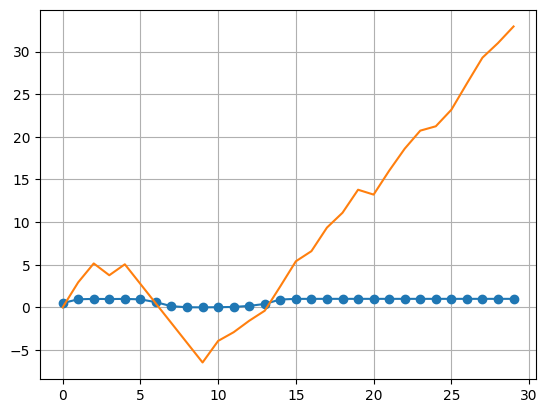

In [50]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
# exploration track score
z_dim = 2
n = 30
hit_vector = np.ones(n)
x_real, y_real = 2.0, 3.0

hit_vector[5:10] = 0

x_noise = x_real + np.sqrt(1.2)*np.random.randn(n)
y_noise = y_real + np.sqrt(0.9)*np.random.randn(n)

S = np.array([[1.2, 0], [0, 0.9]])

Pd = 0.9
Bft = 0.1/100
llr = np.zeros_like(x_noise) # l0 0.5 prob
for i, hit in enumerate(hit_vector):
    if i > 0:
        if hit > 0:
            y = np.array([x_noise[i] - x_real, y_noise[i] - y_real]).reshape(-1, 1)
            dsq = y.T @ np.linalg.inv(S) @ y
            llr[i] = llr[i-1] + np.log(Pd/((2*np.pi)**(z_dim) * Bft * np.sqrt(np.linalg.det(S)))) - dsq/2
        else:
            llr[i] = llr[i-1] + np.log(1-Pd)

prob = np.exp(llr)/(1 + np.exp(llr))

fig, ax = plt.subplots()
ax.plot(prob, '-o')
ax.plot(llr)
ax.grid()


In [51]:
np.log(1-Pd)

-2.302585092994046

In [47]:
hit_vector

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
np.log(Pd/((2*np.pi)**(z_dim) * Bft * np.sqrt(np.linalg.det(S))))

1.989547821269446